## Análisis de IPs reportadas como atacantes por SSH
### Extracción de IPs
Para la realización de este análisis la cátedra proporcionó una lista de IPs que fueron reportadas por conexiones SSH y ataques DDoS

In [4]:
import subprocess

In [2]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

In [10]:
with open("data/IPsSSH.txt") as ips:
    ipSSH = ips.read()
    
ipSSH = ipSSH.replace("\n", " ").split()
ipSSH

['54.144.244.57',
 '188.166.216.223',
 '220.94.228.162',
 '218.92.0.99',
 '116.193.159.2',
 '109.117.92.13',
 '167.99.112.43',
 '89.248.163.219',
 '143.198.204.177',
 '61.177.173.45',
 '8.222.204.225',
 '220.135.119.188']

### Importamos la implementación de las peticiones a la API

In [16]:
#| code-fold: true
!mkdir modulos
!cp ../app/modulos/abuseIPDB.py modulos/abuseIPDB.py

In [24]:
#Importo los modulos necesarios
from modulos.abuseIPDB import AbuseIPDB
import pandas as pd

In [26]:
#Construyo el objeto
apiAbuse = AbuseIPDB()

In [29]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais']

diccDf = {'ip' : []}

for ip in ipSSH:
    diccDf['ip'].append(ip)
    info = apiAbuse.getInfo(ip)
    for key in keys:
        if key in diccDf:
            diccDf[key].append(info[key])
        else:
            diccDf[key] = [info[key]]
    

In [34]:
df = pd.DataFrame(data=diccDf)
df

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais
0,54.144.244.57,True,False,58,NaN,US
1,188.166.216.223,True,False,100,NaN,SG
2,220.94.228.162,True,False,100,NaN,KR
3,218.92.0.99,True,False,100,NaN,CN
4,116.193.159.2,True,False,100,NaN,HK
5,109.117.92.13,True,False,100,NaN,IT
6,167.99.112.43,True,False,100,NaN,US
7,89.248.163.219,True,False,100,NaN,NL
8,143.198.204.177,True,False,100,NaN,SG
9,61.177.173.45,True,False,100,NaN,CN


In [36]:
import pycountry

In [108]:
df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

In [80]:
dfgdp

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais
0,54.144.244.57,True,False,58,United States,USA
1,188.166.216.223,True,False,100,Singapore,SGP
2,220.94.228.162,True,False,100,"Korea, Republic of",KOR
3,218.92.0.99,True,False,100,China,CHN
4,116.193.159.2,True,False,100,Hong Kong,HKG
5,109.117.92.13,True,False,100,Italy,ITA
6,167.99.112.43,True,False,100,United States,USA
7,89.248.163.219,True,False,100,Netherlands,NLD
8,143.198.204.177,True,False,100,Singapore,SGP
9,61.177.173.45,True,False,100,China,CHN


In [101]:
print(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])])

1     SGP
4     HKG
8     SGP
10    SGP
Name: codigoPais, dtype: object


In [110]:
import geopandas as gpd
import matplotlib.pyplot as plt

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [113]:
#| code-fold: true
import numpy as np

In [114]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG' 'SGP']






Pude notar que tanto Hong Kong, como Singapur no estan representadas en el mapa mundi por ser ciudades. Por ello, debo cargarlas desde otro dataset




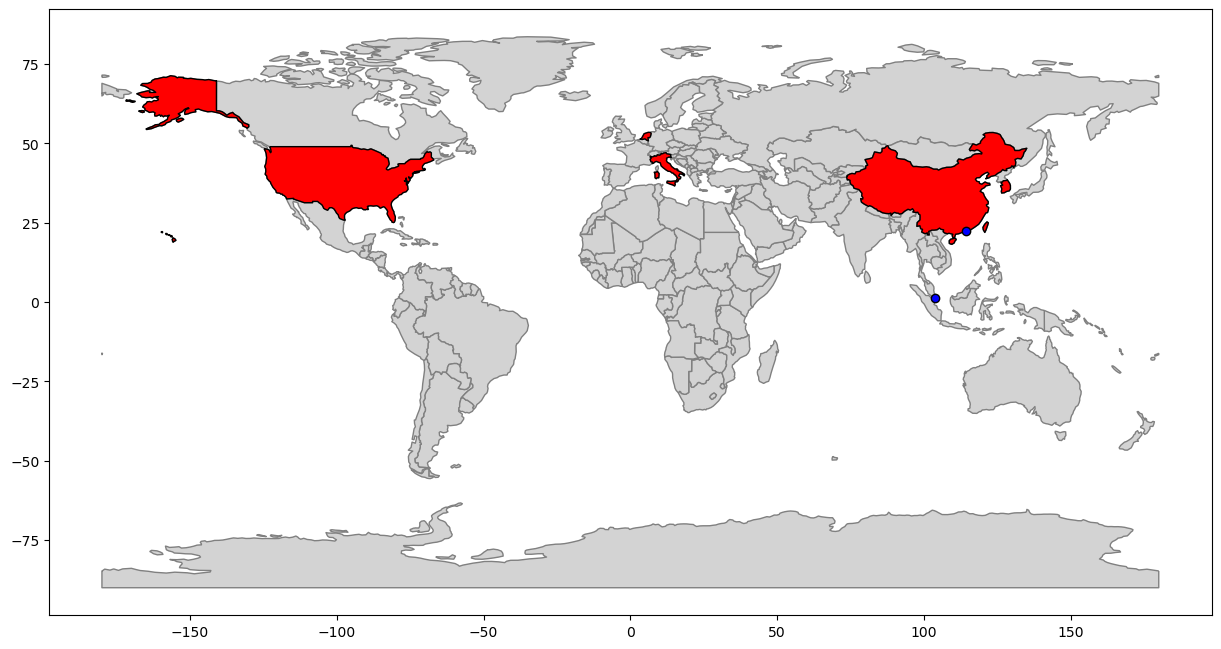

In [117]:
#| label: fig-mapa
#| fig-cap: "Mapa con los lugares del que proceden las IPs"
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

singapur = ciudades[ciudades['name'] == 'Singapore']
hongkong = ciudades[ciudades['name'] == 'Hong Kong']

singapur.plot(ax=ax, edgecolor='black', color='blue')
hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

In [118]:
import seaborn as sns

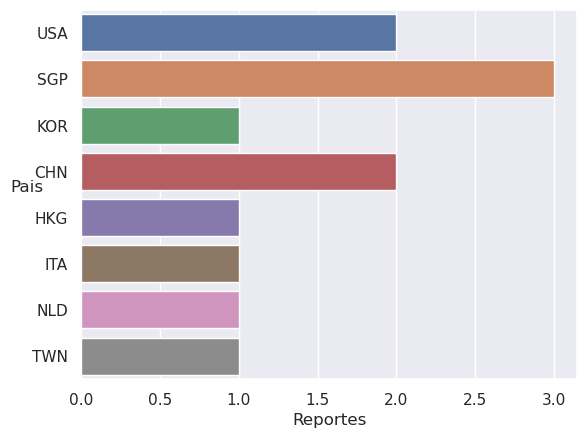

In [162]:
sns.set(style='darkgrid')
sns.countplot(data=dfgdp, y="codigoPais")
ylabel = plt.ylabel("Pais", rotation='horizontal')
plt.xlabel("Reportes")
plt.show()

In [186]:
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Singapore,3
1,United States,2
2,China,2
3,"Korea, Republic of",1
4,Hong Kong,1
5,Italy,1
6,Netherlands,1
7,"Taiwan, Province of China",1
